<a href="https://colab.research.google.com/github/Eslley/AFe-reconhecimento-conversao/blob/main/Trabalho_AFNe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Informe o alfabeto de entrada:
Exemplo do alfabeto de entrada: a b c
Por padrão o símbolo vazio será representado por "e"
a b c

Informe os estados do AFe:
Exemplo: q0 q1 qf
q0 q1 q2 q3 q4 q5 q6 qf

Informe o estado inicial:
q0

Informe os estados finais:
Exemplo: qf qf2
qf

Informe as transições do AFe separadas por "/":
Exemplo: q0 (a) q1/q1 (b) qf
No exemplo acima temos a seguinte transição: estado q0 lendo "a" vai para q1, estado q1 lendo "b" vai para qf
Exemplo: q2 (a,b) q2/q2 (e) q3
No exemplo acima temos a seguinte transição: estado q2 lendo "a" ou "b" vai para q2, estado q2 transição vazia q3
q0 (a,b,c) q0/q0 (e) q1/q0 (e) q2/q0 (e) q4/q1 (a) qf/q2 (b) q3/q3 (b) qf/q4 (c) q5/q5 (c) q6/q6 (c) qf

Digite "sair" para encerrar o reconhecimento
Informe a palavra para realizar o reconhecimento:
ab
Palavra Rejeitada!

Informe a palavra para realizar o reconhecimento:
abb
Palavra Aceita!

Informe a palavra para realizar o reconhecimento:
abcc
Palavra Rejeitada!

Informe a palavra para 

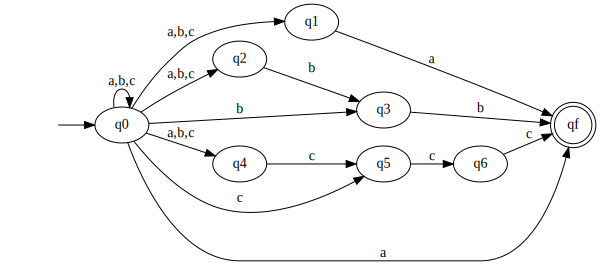

In [1]:
#@title Algoritmo de reconhimento em AFe e conversão AFe -> AFN

import graphviz
from graphviz import Graph
import sys
from copy import deepcopy

class AFNe:

  def __init__(self, alfabeto):
    self.arestas = []
    self.vertices = []
    self.alfabeto = alfabeto
    self.inicial = None
    self.finais = []

  def add_aresta(self, v1, v2):
    aresta = Aresta(v1, v2)
    self.arestas.append(aresta)

    v1.add_aresta(aresta)

    return aresta

  def add_vertice(self, label):
    vertice = Vertice(label)

    self.vertices.append(vertice)

    return vertice

  def find_vertice(self, label):
    for vertice in self.vertices:
      if vertice.get_label() == label:
        return vertice

    return None

  def find_aresta(self, v1, v2):
    for aresta in self.arestas:
      if aresta.getV1() == v1 and aresta.getV2() == v2:
        return aresta

    return None
  
  def set_inicial(self, inicial):
    estado_inicial = self.find_vertice(inicial)
    if estado_inicial == None:
      return False
    else:
      self.inicial = estado_inicial
      return True

  def add_final(self, final):
    estado_final = self.find_vertice(final)
    if estado_final == None:
      return False
    else:
      self.finais.append(estado_final)
      return True

  def computacao_vazia(self, estado):

    estados_alcancados_comp_vazia = []
    for aresta in estado.arestas:
      if 'e' in aresta.transicoes:
        estados_alcancados_comp_vazia += self.computacao_vazia(aresta.getV2()) # chama recursivamente para encontrar transições vazias sucessivas
    
    estados_alcancados_comp_vazia.append(estado)

    return estados_alcancados_comp_vazia

  def processar(self, estado, simbolo): # computa verificando transições vazias
    estados_alcancados_comp_vazia = self.computacao_vazia(estado)

    tem_vazia = False
    tem_loop = False

    for estado_alcancado in estados_alcancados_comp_vazia.copy():
      for aresta in estado_alcancado.arestas:
        for transicao in aresta.transicoes:
          if transicao == 'e':
            tem_vazia = True
          if transicao == simbolo:
            if aresta.getV1() == aresta.getV2():
              tem_loop = True
            if not aresta.getV2() in estados_alcancados_comp_vazia:
              estados_alcancados_comp_vazia.append(aresta.getV2())

    if not tem_vazia and not tem_loop:
      estados_alcancados_comp_vazia.remove(estado)

    return estados_alcancados_comp_vazia

  def computacao(self, estado, simbolo): # sem verificar transicoes vazias
    estados_alcancados = []

    for aresta in estado.arestas:
      for transicao in aresta.transicoes:
        if transicao == simbolo:
          estados_alcancados.append(aresta.getV2())

    return estados_alcancados

  def converter(self):
    automato2 = deepcopy(self)

    for estado_atual in automato2.vertices:
      estados_alcancados_comp_vazia = self.computacao_vazia(estado_atual)

      if len(estados_alcancados_comp_vazia) > 1: # somente estados que tem a transicao vazia

        for estado_alcancado in estados_alcancados_comp_vazia.copy(): # adiciona os novos estados finais
          if estado_alcancado in automato2.finais:
            if not estado_atual in automato2.finais:
              automato2.add_final(estado_atual.get_label())
        
        for simbolo in automato2.alfabeto: # realiza a computação para cada simbolo do alfabeto
          estados_alcancados = []

          for e in estados_alcancados_comp_vazia:
            estados_alcancados += self.computacao(e, simbolo)

          for estado_alcancado in estados_alcancados.copy():
            for alcancado in self.computacao_vazia(estado_alcancado):
              if not alcancado in estados_alcancados:
                estados_alcancados.append(alcancado)

          for estado_alcancado in estados_alcancados: # adiciona as novas transições
            aresta = automato2.find_aresta(estado_atual, estado_alcancado)
            if aresta == None:
              aresta = automato2.add_aresta(estado_atual, estado_alcancado)
              aresta.add_transicao(simbolo)
            else:
              if not simbolo in aresta.transicoes:
                aresta.add_transicao(simbolo)

    for aresta in automato2.arestas: # removes todas as transicoes vazias
      if 'e' in aresta.transicoes:
        aresta.remove_transicao('e')

    return automato2

  def reconhecer(self, palavra):
    for simbolo in palavra: # verifica se a palavra contém símbolos que não pertencem ao alfabeto
      if not simbolo in self.alfabeto:
        return False

    estados_alcancados = self.computacao_vazia(self.inicial) # computação vazia do estado inicial
    estados = []

    for simbolo in palavra: # realiza a computação para cada símbolo

      estados_aux = []

      for estado in estados_alcancados.copy():
        estados = self.computacao(estado, simbolo)
        for e in estados:
          if not e in estados_aux:
            estados_aux.append(e)
      
      estados_alcancados = estados_aux

      for estado in estados_alcancados:
        estados_aux = self.computacao_vazia(estado)
        for e in estados_aux:
          if not e in estados_alcancados:
            estados_alcancados.append(e)

    for final in self.finais: # verifica se algum estado final está no resultado da computação
      if final in estados_alcancados:
        return True

    return False

class Aresta:

  def __init__(self, vertice1, vertice2):
    self.vertice1 = vertice1
    self.vertice2 = vertice2
    self.transicoes = []

  def add_transicao(self, transicao):
    self.transicoes.append(transicao)

  def remove_transicao(self, transicao):
    if transicao in self.transicoes:
      self.transicoes.remove(transicao)
      return True
    else:
      return False

  def transicoes_to_string(self):
    transicoes = ''

    for t in self.transicoes:
      transicoes += t + ','

    return transicoes[:-1] # Remove a última vírgula

  def getV1(self):
    return self.vertice1

  def getV2(self):
    return self.vertice2

class Vertice:

  def __init__(self, label):
    self.label = label
    self.arestas = []

  def get_label(self):
    return str(self.label)

  def add_aresta(self, aresta):
    self.arestas.append(aresta)


alfabeto = input('Informe o alfabeto de entrada:\nExemplo do alfabeto de entrada: a b c\nPor padrão o símbolo vazio será representado por "e"\n')

alfabeto = alfabeto.strip().split(' ')

automato = AFNe(alfabeto)

estados = input('\nInforme os estados do AFe:\nExemplo: q0 q1 qf\n')

for estado in estados.strip().split(' '):
  automato.add_vertice(estado)

estado_inicial = input('\nInforme o estado inicial:\n')

if not automato.set_inicial(estado_inicial):
  print('Estado não encontrado')
  sys.exit(0)

estados_finais = input('\nInforme os estados finais:\nExemplo: qf qf2\n')

for estado in estados_finais.strip().split(' '):
  if not automato.add_final(estado):
    print('Estado ' + estado + ' não encontrado')
    sys.exit(0)

print('\nInforme as transições do AFe separadas por "/":')
print('Exemplo: q0 (a) q1/q1 (b) qf')
print('No exemplo acima temos a seguinte transição: estado q0 lendo "a" vai para q1, estado q1 lendo "b" vai para qf')
print('Exemplo: q2 (a,b) q2/q2 (e) q3')
print('No exemplo acima temos a seguinte transição: estado q2 lendo "a" ou "b" vai para q2, estado q2 transição vazia q3')

transicoes = input('')

for transicao in transicoes.strip().split('/'):
  transicao = transicao.strip().split(' ')
  v1 = automato.find_vertice(transicao[0])
  simbolos = transicao[1].replace('(', '').replace(')', '').split(',')
  v2 = automato.find_vertice(transicao[2])

  if v1 == None or v2 == None:
    print('Vertice não encontrado')
    sys.exit(0)
  else:
    aresta = automato.add_aresta(v1, v2)
    for simbolo in simbolos:
      aresta.add_transicao(simbolo)

continuar = True

print('\nDigite "sair" para encerrar o reconhecimento')
while continuar:
    palavra = input('Informe a palavra para realizar o reconhecimento:\n')

    if palavra == 'sair':
        break

    if automato.reconhecer(palavra):
        print("Palavra Aceita!\n")
    else:
        print("Palavra Rejeitada!\n")

print('\nAFe Convertido para AFN:\n')

automato = automato.converter()

automatoTable = graphviz.Digraph('AFe', filename='process.gv', format='png', graph_attr={'rankdir':'LR'})
for v in automato.vertices:
  if not v == automato.inicial and not v in automato.finais:
    automatoTable.attr('node')
    automatoTable.node(v.get_label())

  if v in automato.finais:
    automatoTable.node(v.get_label(), shape='doublecircle')

for a in automato.arestas:
  automatoTable.edge(a.getV1().get_label(),a.getV2().get_label(), a.transicoes_to_string())

automatoTable.attr('node', style='invis')

automatoTable.edge('',automato.inicial.get_label())

automatoTable


In [ ]:
#@title Dados de teste

#Dados de entrada para teste 1 / RECONHECE SUFIXO a ou bb ou ccc
alfabeto = 'a b c'
estados = 'q0 q1 q2 q3 q4 q5 q6 qf' 
estado_inicial = 'q0'
estados_finais = 'qf'
transicoes = 'q0 (a,b,c) q0/q0 (e) q1/q0 (e) q2/q0 (e) q4/q1 (a) qf/q2 (b) q3/q3 (b) qf/q4 (c) q5/q5 (c) q6/q6 (c) qf'

#Dados de entrada para teste 2 / RECONHECE ou N° par de 0's ou dois 1's
alfabeto = '0 1' 
estados = 'q0 q1 q2 q3 q4 q5'
estado_inicial = 'q0'
estados_finais = 'q1 q5'
transicoes = 'q0 (e) q1/q0 (e) q3/q1 (1) q1/q1 (0) q2/q2 (1) q2/q2 (0) q1/q3 (0) q3/q3 (1) q4/q4 (0) q4/q4 (1) q5/q5 (0) q5'

#Dados de entrada para teste 3 / RECONHECE a*b*
alfabeto = 'a b c'
estados = 'q0 q1 q2'
estado_inicial = 'q0'
estados_finais = 'q2'
transicoes = 'q0 (a) q0/q0 (e) q1/q1 (b) q1/q1 (e) q2/q2 (a) q2'

#Dados de entrada para teste 4 / RECONHECE SUBPALAVRA abc
alfabeto = 'a b'
estados = 'q0 q1 q2 q3 q4 q5 q6 q7' 
estado_inicial = 'q0'
estados_finais = 'q7'
transicoes = 'q0 (a,b,c) q0/q0 (e) q1/q1 (a) q2/q2 (e) q3/q3 (b) q4/q4 (e) q5/q5 (c) q6/q6 (e) q7/q7 (a,b,c) q7'

#Dados de entrada para teste 5 / RECONHECE SUBPALAVRA ab
alfabeto = 'a b'
estados = 'q0 q1 q2 q3 q4 q5'
estado_inicial = 'q0'
estados_finais = 'q5'
transicoes = 'q0 (a,b) q0/q0 (e) q1/q1 (a) q2/q2 (e) q3/q3 (b) q4/q4 (e) q5/q5 (a,b) q5'
